In [1]:
import modules.nn_functions as nnf
from sklearn.model_selection import train_test_split
import polars as pl
import matplotlib.pyplot as plt
from functools import partial
import jax.numpy as jnp
from tqdm import tqdm

In [2]:
### Data preprocessing

df = pl.read_csv("data/IRIS.csv")
inputs = df.drop("species")
labels = df.select("species")
classifications = []
for label in labels.iter_rows():
    if label[0] not in classifications:
        classifications.append(label[0])
labels = labels.with_columns(pl.col("species").replace_strict(classifications, list(range(len(classifications)))))

inputs = inputs.to_jax()
labels = labels.to_jax()

inputs_train, inputs_test, labels_train, labels_test = train_test_split(inputs, labels, test_size=0.4, random_state=0)

In [3]:
### Defining hyperparameters
model_dim = (4, 128, 3)
num_seeds = 100
epochs = 100
batch_size_initial = 10
batch_size_final = 10
lr_initial = 0.01
lr_final = 0.0001
lr_tau = epochs / 10

### Defining variable batch size and learning rate functions
batch_size_func = partial(nnf.batch_size_linear, batch_size_initial, batch_size_final, epochs)
lr_func = partial(nnf.learning_rate_decay, lr_initial, lr_final, lr_tau)

In [ ]:
### Training

train_losses = None
test_losses = None
test_percents = None
epochs_arr = None

for seed in tqdm(range(num_seeds)):
    # model = nn(model_dim, seed=seed)
    model_params = nnf.initialise_params(model_dim, seed=seed)
    model_params, train_loss, test_loss, test_percent = nnf.train(model_params, inputs_train, labels_train, inputs_test, labels_test, epochs, batch_size_func, lr_func, seed=seed)

    train_loss = jnp.expand_dims(train_loss, axis=0)
    test_loss = jnp.expand_dims(test_loss, axis=0)
    test_percent = jnp.expand_dims(test_percent, axis=0)
    
    if train_losses is not None:
        assert test_percents is not None and test_losses is not None
        train_losses = jnp.append(train_losses, train_loss, axis=0)
        test_losses = jnp.append(test_losses, test_loss, axis=0)
        test_percents = jnp.append(test_percents, test_percent, axis=0)
    else:
        train_losses = train_loss
        test_losses = test_loss
        test_percents = test_percent
    

100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


In [5]:
### Statistical analysis

mean_train_loss = jnp.mean(train_losses, axis=0)
std_train_loss = jnp.std(train_losses, axis=0, ddof=1)
mean_test_loss = jnp.mean(test_losses, axis=0)
std_test_loss = jnp.std(test_losses, axis=0, ddof=1)
mean_test_percent = jnp.mean(test_percents, axis=0)
std_test_percent = jnp.std(test_percents, axis=0, ddof=1)
epochs_arr = jnp.arange(1, mean_train_loss.shape[0]+1)

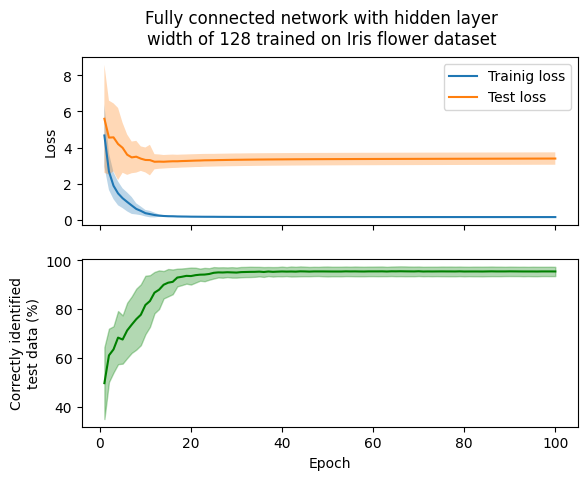

In [7]:
### Plots

fig, axs = plt.subplots(2, 1, sharex=True)

fig.suptitle("Fully connected network with hidden layer\nwidth of 128 trained on Iris flower dataset")

axs[0].plot(epochs_arr, mean_train_loss, label="Trainig loss")
axs[0].fill_between(epochs_arr, mean_train_loss-std_train_loss, mean_train_loss+std_train_loss, alpha=0.3)
axs[0].plot(epochs_arr, mean_test_loss, label="Test loss")
axs[0].fill_between(epochs_arr, mean_test_loss-std_test_loss, mean_test_loss+std_test_loss, alpha=0.3)
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(epochs_arr, mean_test_percent, color="green")
axs[1].fill_between(epochs_arr, mean_test_percent-std_test_percent, mean_test_percent+std_test_percent, alpha=0.3, color="green")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Correctly identified\ntest data (%)")

plt.savefig("plots/plot.png")